# Mossley Hill Church: Geographic Data Science Internship

In [97]:
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot
import os.path
import osmnx as ox
import networkx as nx
import requests
import json

In [225]:
one_mile = 1609 #meters
immediate_neighbourhood = ox.graph_from_point(church_coords, distance=1*one_mile, network_type='drive')

In [312]:
def get_postcode_coords(postcodes):
    postcode_data = {}
    for postcode in postcodes:
        postcode_data[postcode] = json.loads(requests.get(url+'/'+postcode).text)
    coords = {}
    for postcode in postcodes:
        try:
            coords[postcode] = postcode_data[postcode]['result']['latitude'], postcode_data[postcode]['result']['longitude']
        except:
            coords[postcode] = 'not found'
    return coords

In [343]:
church_postcode = 'L18 8DB'
church_coords = (53.376628, -2.920006)

## The Congregation

In [394]:
electoral_roll = pd.read_csv('electoral-roll.csv')

In [116]:
len(electoral_roll)

242

There are 242 people on the church electoral roll.

In [387]:
ages = pd.read_excel('mossley-hill-numbers.xlsx', sheet_name='Regulars', index_col=1)

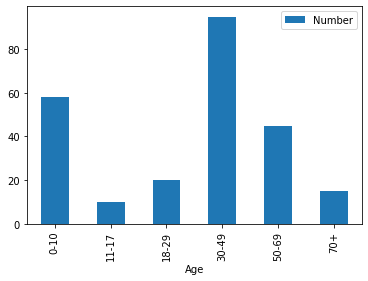

In [391]:
ages[0:6].plot.bar()

In [58]:
electoral_roll.Sex.value_counts()

f    158
m     84
Name: Sex, dtype: int64

There are almost twice as many women as men.

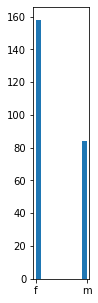

In [56]:
electoral_roll.Sex.hist(grid=False, figsize=(1,5))

In [70]:
postcodes = list(electoral_roll.Postcode.unique())

In [290]:
len(postcodes)

149

There are 149 unique postcodes. Families (within a household) must share a postcode, though not everyone who shares a postcode is necessarily in the same household. If we assume that everyone sharing a postcode is part of the same household, then there might be 18 families with a couple and one or more children.

In [398]:
electoral_roll.Postcode.value_counts()[0:20]

L17 0DH    6
L19 9DB    6
L18 4QG    5
L18 5HY    5
L19 9DA    4
L18 4QH    4
L18 4PP    4
L18 5ET    3
L18 4PZ    3
L19 7NN    3
L18 4PR    3
L19 7Nf    3
L18 4RJ    3
L18 2DY    3
L18 5EL    3
L17 0DG    3
L19 3PL    3
L18 4QW    3
L17 6BG    2
L18 3HB    2
Name: Postcode, dtype: int64

In [112]:
coords = get_postcode_coords(postcodes)

In [134]:
one_mile = 1609 #meters
G = ox.graph_from_point(church_coords, distance=10*one_mile, network_type='drive')
fig, ax = ox.plot_graph(G, fig_height=20, node_size=0)

In [121]:
# save graph to disk as shapefile (for GIS) or graphml file (for gephi etc)
ox.save_graph_shapefile(G, filename='mynetwork_shapefile')
ox.save_graphml(G, filename='mynetwork.graphml')

In [139]:
G2 = ox.load_graphml('mynetwork.graphml')

In [164]:
dest_node = ox.get_nearest_node(G, mossley_hill)
shortest_path = {}
distance = {}
for postcode in postcodes:
    
    try:
        orig_node = ox.get_nearest_node(G, coords[postcode])
        shortest_path[postcode] = nx.shortest_path(G, orig_node, dest_node, weight='length')
        # how long is our route in meters?
        distance[postcode] = nx.shortest_path_length(G, orig_node, dest_node, weight='length') / one_mile
    except:
        pass

In [136]:
all_routes = []
for postcode in postcodes:
    try:
        all_routes.append(shortest_path[postcode])
    except:
        pass

In [228]:
nearby = {}
nearby_postcodes = []
nearby_routes = []
for postcode in postcodes:
    try:
        if distance[postcode] < 1:
            nearby_postcodes.append(postcode)
            nearby_routes.append(shortest_path[postcode])
    except:
        pass

In [243]:
len(nearby_postcodes)

82

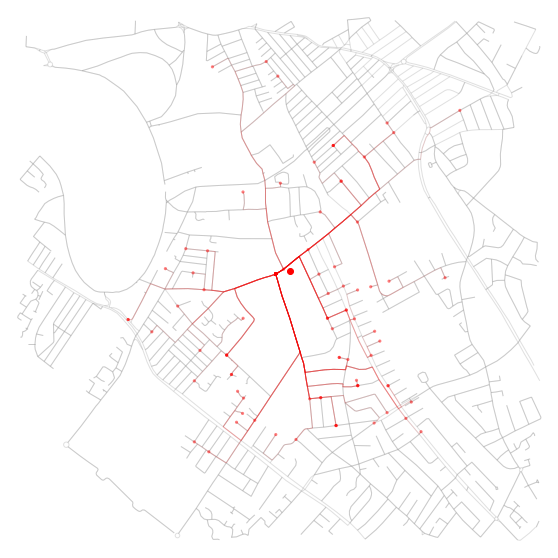

In [393]:
fig, ax = ox.plot_graph_routes(immediate_neighbourhood, nearby_routes, fig_height=10, node_size=0, orig_dest_node_size=10, edge_alpha=0.3, route_alpha=0.1, route_linewidth=1, show=False, close=False)
# for p in church_postcodes:
#     c = other_church_coords[p]
#     ax.scatter(c[1],c[0],c = 'blue')
ax.scatter(church_coords[1], church_coords[0], c='red')
plt.show()

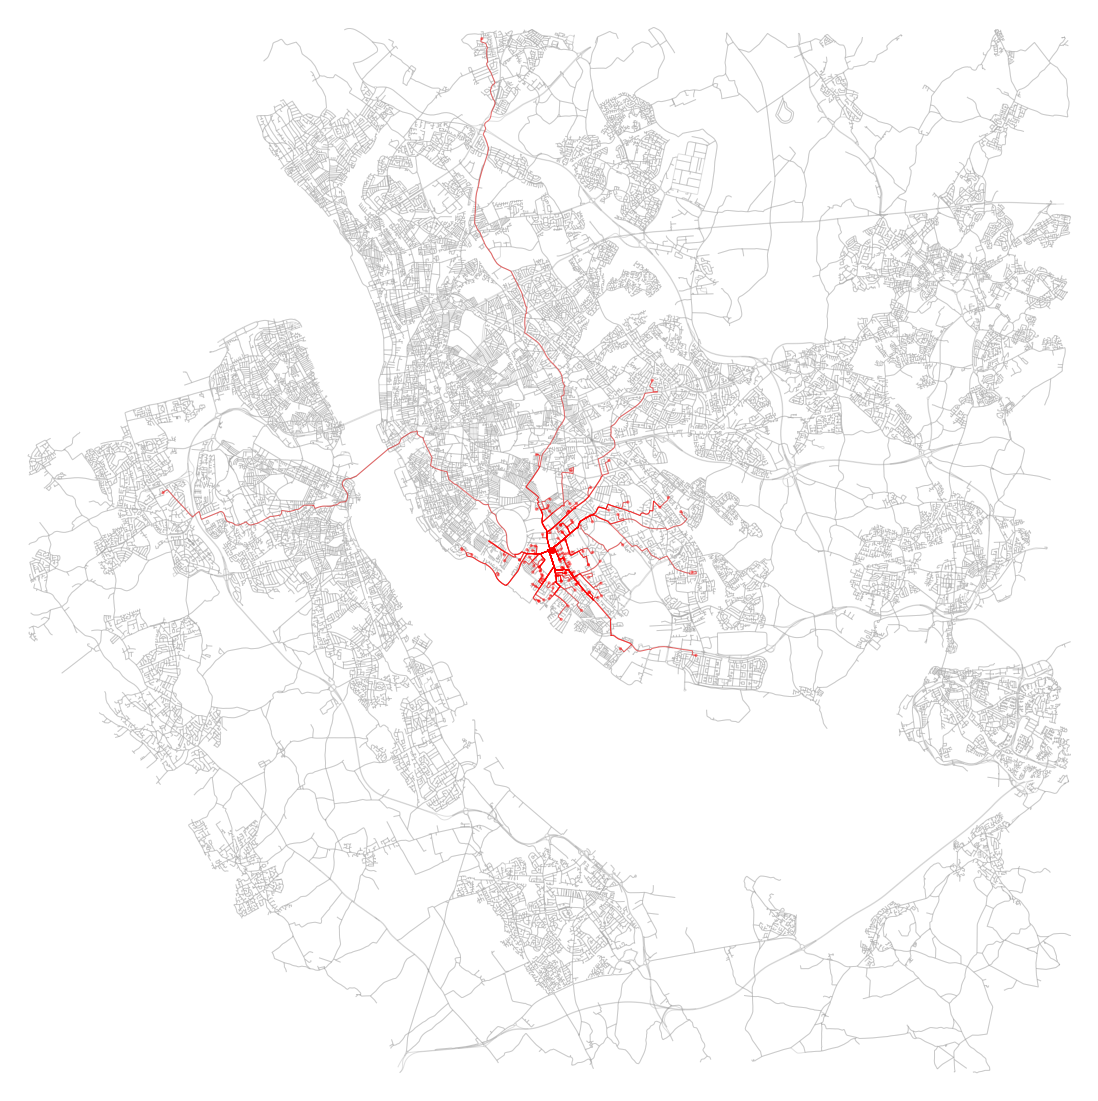

In [392]:
# plot the routes https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.plot
fig, ax = ox.plot_graph_routes(G2, all_routes, fig_height=20, node_size=0, orig_dest_node_size=10, edge_alpha=0.3, route_linewidth=1, show=False, close=False)
# for p in church_postcodes:
#     c = other_church_coords[p]
#     ax.scatter(c[1],c[0],c = 'blue')
ax.scatter(church_coords[1], church_coords[0], c='red')
plt.show()

In [165]:
dist = pd.DataFrame(distance, index=['Distance']).transpose()

electoral_roll.set_index('Postcode', inplace=True)

In [181]:
electoral_roll.insert(loc=1,column='Distance',value=dist.Distance)

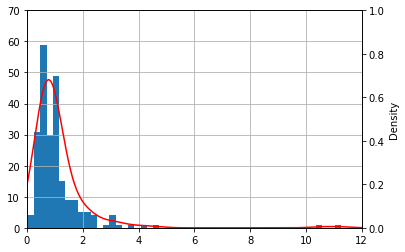

In [211]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_ylim(0,70)
ax2.set_ylim(0,1)
ax.set_xlim(0,12)
electoral_roll.Distance.hist(bins=50, ax=ax)
electoral_roll.Distance.plot.kde(ax=ax2, c = 'r')

In [311]:
electoral_roll.Distance.describe()

count    231.000000
mean       1.101576
std        1.146467
min        0.035313
25%        0.615764
50%        0.874070
75%        1.159034
max       11.250470
Name: Distance, dtype: float64

In [318]:
print('Furthest')
electoral_roll.sort_values('Distance', ascending=False)[0:20].transpose()

Furthest


Postcode,L31 8DW,CH49 4PD,L14 9QB,L24 3Th,L25 9NT,L25 2QH,L25 2RR,L25 2RR,L19 2RR,L19 2RR,L25 4SB,L17 7EP,L16 6AY,L16 6AY,L17 7HP,L15 8GB,L15 8GB,L15 4NB,L15 4NB,L16 0Jf
Sex,f,f,f,f,m,m,f,m,m,f,f,m,f,m,f,m,f,m,f,m
Distance,11.2505,10.5257,4.60278,4.08824,3.78874,3.32793,3.1734,3.1734,2.98799,2.98799,2.91831,2.43492,2.34842,2.34842,2.34566,2.27451,2.27451,2.25904,2.25904,2.06387


In [319]:
print('Nearest')
electoral_roll.sort_values('Distance',)[0:20].transpose()

Nearest


Postcode,L18 8DB,L18 8DB,L18 4QB,L18 4QE,L17 0DH,L17 0DH,L17 0DH,L17 0DH,L17 0DH,L17 0DH,L18 4Qf,L18 4Qf,L18 8AJ,L18 8AJ,L18 4PZ,L18 4PH,L18 4PH,L18 4PZ,L18 4PZ,l17 0DT
Sex,f,f,f,f,f,m,f,f,f,f,f,m,f,m,f,f,m,m,f,f
Distance,0.0353132,0.0353132,0.155769,0.25053,0.286967,0.286967,0.286967,0.286967,0.286967,0.286967,0.331271,0.331271,0.37292,0.37292,0.373493,0.373493,0.373493,0.373493,0.373493,0.394382


In [316]:
electoral_roll.loc[electoral_roll.Distance.isnull()].transpose()

Postcode,L18 4AU,L17 0RQ,L18 4 RN,L17 6OA,Merseyside,L17 3PG,L18 3DS,L17 6OH,Merseyside,Liverpool,l17
Sex,f,m,f,m,f,m,m,m,f,m,m
Distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## The Parish

[Mossley Hill Church](https://mossleyhillchurch.org.uk/who-we-are/), Rose Lane, Liverpool L18 8DB.

>The Church of St Matthew and St James stands at the top of the hill in Rose Lane, Mossley Hill, Liverpool. It is an active Anglican parish church in the deanery of Liverpool South Childwall, the archdeaconry of Liverpool and the diocese of Liverpool. The church is recorded in the National Heritage List for England as a designated Grade II* listed building. The authors of the Buildings of England series describe it as "one of the best Victorian churches in Liverpool"

In [332]:
churches = pd.read_csv('other-churches.csv')

In [336]:
church_postcodes = list(churches.Postcode)

In [338]:
other_church_coords = get_postcode_coords(church_postcodes)

In [377]:
churchlist = ''
for church in churches.Church:
    churchlist += church + '; '

print(f'**Nearby Churches**: {churchlist[:-2]}')

**Nearby Churches**: Allerton URC; All Souls; All Hallows; Carmelite Monastery; Garston Park Church; Long Lane Church; St Mary's Grassendale; Mossley Hill Church; St Francis of Assissi Church; St Barnabas Penny Lane; Aigburth Community Church; St Peter's Church; Liverpool Roman Catholic Archdiocesan Trust; St Anthony's Friary; Our Lady of the Annuniciation - Bishop Eton; St James' Church; Elm Hall Drive Methodist Church; Liverpool District Methodist Church; Cornerstone Church Liverpool; Farnworth Church; Catholic Church of St Thomas More; Wavertree Christian Fellowship; St Anne's Aigburth; St Mary's Church, Woolton; St Hilda's Church; Hamlet Baptist Church; Christ Church, Toxteth Park; Gateway Church; St Charles R.C. Church; St Columba URC Church; Grace Family Church; St Michael's Hamlet; St Anthony of Padua RC Church; Holy Family Catholic Church; Saint Charles Borromeo R.C. Church; Parish of St John Vianney; Jubilee Church Liverpool.

In [358]:
churches.transpose()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
Church,Allerton URC,All Souls,All Hallows,Carmelite Monastery,Garston Park Church,Long Lane Church,St Mary's Grassendale,Mossley Hill Church,St Francis of Assissi Church,St Barnabas Penny Lane,...,Gateway Church,St Charles R.C. Church,St Columba URC Church,Grace Family Church,St Michael's Hamlet,St Anthony of Padua RC Church,Holy Family Catholic Church,Saint Charles Borromeo R.C. Church,Parish of St John Vianney,Jubilee Church Liverpool
Postcode,L18 7HD,L19 4TF,L18 6JJ,L18 3NU,L19 9AF,L19 6PF,L19 2LD,L18 8DB,L19 1RT,L18 1LZ,...,L24 9HJ,L17 9PG,L25 0NR,L17 9PE,L17 7BB,L18 8AY,L25 8TG,L17 9PG,L26 0UG,L17 3AL


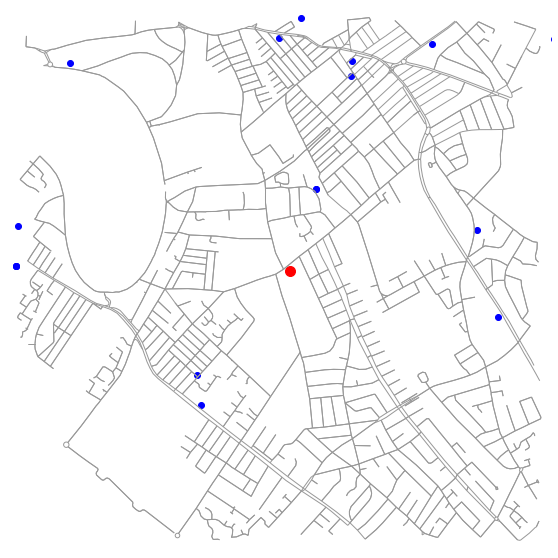

In [344]:
fig, ax = ox.plot_graph(immediate_neighbourhood, fig_height=10, node_size=0, show=False, close=False)
for p in church_postcodes:
    c = other_church_coords[p]
    ax.scatter(c[1],c[0],c = 'blue')
ax.scatter(church_coords[1], church_coords[0], c='red', s=100)
plt.show()

In [303]:
def get_street_names(coords, miles):
    neighbourhood_graph = ox.project_graph(ox.graph_from_point(coords, distance=miles*one_mile, network_type='drive'))
    ints = ox.clean_intersections(neighbourhood_graph)

    gdf = gpd.GeoDataFrame(ints, columns=['geometry'], crs=neighbourhood_graph.graph['crs'])
    X = gdf['geometry'].map(lambda pt: pt.coords[0][0])
    Y = gdf['geometry'].map(lambda pt: pt.coords[0][1])

    nodes = ox.get_nearest_nodes(neighbourhood_graph, X, Y, method='kdtree')
    nearby_streets = {'Rose Lane'}
    for n in nodes:
        for nbr in nx.neighbors(neighbourhood_graph, n):
            for d in neighbourhood_graph.get_edge_data(n, nbr).values():
                if 'name' in d:
                    if type(d['name']) == str:
                        nearby_streets.add(d['name'])
                    elif type(d['name']) == list:
                        for name in d['name']:
                            nearby_streets.add(name)
                    else:
                        pass
                else:
                    pass

    return nearby_streets

In [399]:
miles = 0.5
nearby_streets = get_street_names(church_coords, miles)
print(f'There are {len(nearby_streets)} streets within {miles} miles of the church.')
print(nearby_streets)

There are 110 streets within 0.5 miles of the church.
{'Brodie Avenue', 'Lochmore Road', 'Erylmore Road', 'Aigburth Vale', 'Molyneux Road', 'Hollywood Road', 'Pitville Road', 'Victoria Road', 'Glenmore Avenue', 'Rose Lane', 'Templemore Avenue', 'Gladeville Road', 'Kelton Grove', 'Rangemore Road', 'Briarwood Road', 'Aigburth Road', 'Carnatic Road', 'Lammermoor Road', 'Avonmore Avenue', 'Pinemore Road', 'Donalds Way', 'Craigmore Road', 'Garthdale Road', 'Sudley Grange', 'Kylemore Avenue', 'Sands Road', 'Boxmoor Road', 'Pitville Grove', 'Martin Close', 'Cyril Grove', 'Pitville Close', 'Palmerston Close', 'Heatherdale Road', 'Dundonald Road', 'Cooper Avenue North', 'Edale Road', 'Elmswood Road', 'Mather Avenue', 'Ashlar Grove', 'Elmar Road', 'Mossville Road', 'Queens Drive', 'Palmerston Road', 'Purley Grove', 'Lugard Road', 'Mossley Hill Drive', 'Crawford Park', 'Rimmington Road', 'Birchtree Road', 'Milner Road', 'Carrickmore Avenue', 'Mossville Close', 'Barkhill Road', 'North Sudley Road'

In [ ]:
# get neighbourhood data
age
ethnicity
income
house prices
deprivation